## Import the required libraries and the utility modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 12.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

#Custom libraries
#Data formating library
from dataloadinglibrary import loadCSV

from datainspection1 import getStatisticsOfData

from dataformatinglibrary import createExcelFromArray

from Inputs import getLabelName
from Inputs import getPathToTrainingAndTestingDataSets
from Inputs import modelPerformanceReport
from Inputs import defineArrayForPreProcessing
from Inputs import getPathToGenerateModels

from utilss3 import performPreprocessing

### Load the training dataset and check the statistics

In [ ]:
#Define file names and call loadCSV to load the CSV files
trainingFileNameWithAbsolutePath, testingFileNameWithAbsolutePath = getPathToTrainingAndTestingDataSets()
trainingDataSet = loadCSV(trainingFileNameWithAbsolutePath)
difficultyLevel = trainingDataSet.pop('difficulty_level')
labelName = getLabelName()
label = trainingDataSet[labelName]

#Look at the statistics of the dataSet
getStatisticsOfData(trainingDataSet)
print("\n***** Here is how to training dataset looks like before performing any pre-processing *****")
trainingDataSet.head()

***** Start checking the statistics of the dataSet *****

***** Shape (number of rows and columns) in the dataset:  (25191, 42)
***** Total number of features in the dataset:  41
***** Number of categorical features in the dataset:  3
***** Number of numerical features in the dataset:  38

***** Names of categorical features in dataset *****

| Categorical features in dataset   |
|-----------------------------------|
| Service                           |
| Protocol_type                     |
| Flag                              |


***** Names of numerical features in dataset *****

| Numerical features in the dataset   |
|-------------------------------------|
| Duration                            |
| Src_bytes                           |
| Dst_bytes                           |
| Land                                |
| Wrong_fragment                      |
| Urgent                              |
| Hot                                 |
| Num_failed_logins                   |
| Logged_in

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,...,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack_type
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


### Load the testing dataset and check the statistics

In [ ]:
#Define file names and call loadCSV to load the CSV files
testingDataSet = loadCSV(testingFileNameWithAbsolutePath)
difficultyLevel = testingDataSet.pop('difficulty_level')

#Look at the statistics of the dataSet
getStatisticsOfData(testingDataSet)
print("\n***** Here is how to testing dataset looks like before performing any pre-processing *****")
testingDataSet.head()

***** Start checking the statistics of the dataSet *****

***** Shape (number of rows and columns) in the dataset:  (11850, 42)
***** Total number of features in the dataset:  41
***** Number of categorical features in the dataset:  3
***** Number of numerical features in the dataset:  38

***** Names of categorical features in dataset *****

| Categorical features in dataset   |
|-----------------------------------|
| Service                           |
| Protocol_type                     |
| Flag                              |


***** Names of numerical features in dataset *****

| Numerical features in the dataset   |
|-------------------------------------|
| Duration                            |
| Src_bytes                           |
| Dst_bytes                           |
| Land                                |
| Wrong_fragment                      |
| Urgent                              |
| Hot                                 |
| Num_failed_logins                   |
| Logged_in

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,...,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack_type
0,13,tcp,telnet,SF,118,2425,0,0,0,0,...,10,0.38,0.12,0.04,0.0,0.00,0.00,0.12,0.3,guess_passwd
1,0,udp,private,SF,44,0,0,0,0,0,...,254,1.00,0.01,0.01,0.0,0.00,0.00,0.00,0.0,snmpguess
2,0,tcp,telnet,S3,0,44,0,0,0,0,...,79,0.31,0.61,0.00,0.0,0.21,0.68,0.60,0.0,processtable
3,0,udp,private,SF,53,55,0,0,0,0,...,255,1.00,0.00,0.87,0.0,0.00,0.00,0.00,0.0,normal
4,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.06,1.00,1.00,0.0,1.00,1.00,0.00,0.0,nmap


### Perform pre-processing

In [ ]:
arrayOfModels = defineArrayForPreProcessing()
completeEncodedAndScaledDataset = performPreprocessing(trainingDataSet, testingDataSet, arrayOfModels)
completeEncodedAndScaledDataset.head()

[['ExtraTreesClassifier', 'OneHotEncoder', 'Standardization']]
***************************************************************************************************************************
********************************************* Building Model- 0  As Below *************************************************
	 -- Feature Selection: 	  ExtraTreesClassifier  
	 -- Feature Encoding: 	  OneHotEncoder  
	 -- Feature Scaling: 	  Standardization 

completeDataSet.shape:  (37041, 43)
completeDataSet.head:     Duration Protocol_type  Service Flag  Src_bytes  Dst_bytes  Land  \
0         0           udp    other   SF        146          0     0   
1         0           tcp  private   S0          0          0     0   
2         0           tcp     http   SF        232       8153     0   
3         0           tcp     http   SF        199        420     0   
4         0           tcp  private  REJ          0          0     0   

   Wrong_fragment  Urgent  Hot  ...  Dst_host_same_srv_rate  \
0    

,Protocol_type,Service,Flag,Src_bytes,Logged_in,Count,Serror_rate,Srv_serror_rate,Rerror_rate,Same_srv_rate,...,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,difficulty_level,attack_type
0,2.038571,0.629977,0.735369,-0.011190,-0.732914,-0.581217,-0.556584,-0.552030,-0.460806,-1.421427,...,0.656445,-1.050270,-1.193023,2.187298,2.137976,-0.561390,-0.549814,-0.487765,-0.853801,normal
1,-0.154786,0.938904,-0.660992,-0.011262,-0.732914,0.275339,1.851192,1.851769,-0.460806,-1.491319,...,0.656445,-0.821669,-0.966271,-0.237144,-0.498320,1.904034,1.899674,-0.487765,0.228139,neptune
2,-0.154786,-0.543948,0.735369,-0.011147,1.364417,-0.643512,-0.075029,-0.071270,-0.460806,0.721924,...,-1.709884,1.272317,1.074493,-0.457548,-0.408446,-0.487427,-0.525319,-0.487765,0.769108,normal
3,-0.154786,-0.543948,0.735369,-0.011163,1.364417,-0.448840,-0.556584,-0.552030,-0.460806,0.721924,...,0.656445,1.272317,1.074493,-0.457548,-0.498320,-0.561390,-0.549814,-0.487765,0.769108,normal
4,-0.154786,0.938904,-2.057353,-0.011262,-0.732914,0.259766,-0.556584,-0.552030,2.274941,-1.235049,...,0.656445,-0.885678,-1.034297,-0.148983,-0.498320,-0.561390,-0.549814,2.476323,0.769108,neptune


### After preprocessing, check the shape of the dataset

In [ ]:
x = completeEncodedAndScaledDataset.drop('attack_type',axis=1)
y = completeEncodedAndScaledDataset['attack_type']
print(x.shape, y.shape)
print('Number of unique values in label: ',len(np.unique(y)))
print('Unique values in label: ',np.unique(y))
#print(y.value_counts())

(37041, 20) (37041,)
Number of unique values in label:  40
Unique values in label:  ['apache2' 'back' 'buffer_overflow' 'ftp_write' 'guess_passwd'
 'httptunnel' 'imap' 'ipsweep' 'land' 'loadmodule' 'mailbomb' 'mscan'
 'multihop' 'named' 'neptune' 'nmap' 'normal' 'perl' 'phf' 'pod'
 'portsweep' 'processtable' 'ps' 'rootkit' 'saint' 'satan' 'sendmail'
 'smurf' 'snmpgetattack' 'snmpguess' 'spy' 'sqlattack' 'teardrop'
 'udpstorm' 'warezclient' 'warezmaster' 'worm' 'xlock' 'xsnoop' 'xterm']


### Encoding the categorical label values

In [ ]:
onehot = pd.get_dummies(y)
y = onehot.values
print(x.shape, y.shape)

(37041, 20) (37041, 40)


## Build a neural Network model

In [ ]:
"""def nn_model(trainx, trainy, valx,valy,bt_size,epochs, layers):
  model = Sequential()
  model.add(Dense(layers[0],activation='relu', input_shape=(trainx.shape[1],)))
  for l in layers[1:]:
    model.add(Dense(l, activation='relu' ))
    model.add(Dropout(0.25))
  model.add(Dense(trainy.shape[1], activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  hist = model.fit(trainx, trainy, batch_size=bt_size, epochs=epochs, shuffle=True, validation_data=(valx,valy), verbose=True)
  return hist

In [ ]:
"""trainx, testx, trainy, testy = train_test_split(x,y, test_size=0.20, random_state=42)
layers=[trainx.shape[1],900,600,400,300,200,100,50,38]
hist = nn_model(trainx, trainy, testx, testy,16,150,layers)

Epoch 1/150
 313/1852 [====>.........................] - ETA: 10s - loss: 1.4102 - accuracy: 0.6328

KeyboardInterrupt: ignored

In [ ]:
layers=[trainx.shape[1],900,600,400,300,200,100,50,38]
trainx, testx, trainy, testy = train_test_split(x,y, test_size=0.20, random_state=42)

In [ ]:
layers=[trainx.shape[1],900,600,400,300,200,100,50,38]
trainx, testx, trainy, testy = train_test_split(x,y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(layers[0],activation='relu', input_shape=(trainx.shape[1],)))
for l in layers[1:]:
  model.add(Dense(l, activation='relu' ))
  model.add(Dropout(0.25))
model.add(Dense(trainy.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 900)               18900     
                                                                 
 dropout_16 (Dropout)        (None, 900)               0         
                                                                 
 dense_22 (Dense)            (None, 600)               540600    
                                                                 
 dropout_17 (Dropout)        (None, 600)               0         
                                                                 
 dense_23 (Dense)            (None, 400)               240400    
                                                                 
 dropout_18 (Dropout)        (None, 400)              

In [ ]:
model3 = model.fit(trainx, trainy, batch_size=16, epochs=120, shuffle=True, validation_data=(testx,testy), verbose=True)

Epoch 1/120
1852/1852 [==============================] - 16s 8ms/step - loss: 0.8312 - accuracy: 0.7686 - val_loss: 0.4509 - val_accuracy: 0.8746
Epoch 2/120
1852/1852 [==============================] - 15s 8ms/step - loss: 0.4598 - accuracy: 0.8737 - val_loss: 0.3094 - val_accuracy: 0.8996
Epoch 3/120
1852/1852 [==============================] - 14s 8ms/step - loss: 0.3689 - accuracy: 0.8977 - val_loss: 0.2806 - val_accuracy: 0.9127
Epoch 4/120
1852/1852 [==============================] - 14s 8ms/step - loss: 0.3224 - accuracy: 0.9123 - val_loss: 0.3301 - val_accuracy: 0.9079
Epoch 5/120
1852/1852 [==============================] - 14s 8ms/step - loss: 0.2996 - accuracy: 0.9172 - val_loss: 0.2341 - val_accuracy: 0.9271
Epoch 6/120
1852/1852 [==============================] - 15s 8ms/step - loss: 0.2802 - accuracy: 0.9229 - val_loss: 0.2122 - val_accuracy: 0.9316
Epoch 7/120
1852/1852 [==============================] - 14s 7ms/step - loss: 0.2629 - accuracy: 0.9278 - val_loss: 0.2639 -

In [ ]:
print('MAX Accuracy during training: ',max(model3.history['accuracy'])*100)
print('MAX Accuracy during validation: ',max(model3.history['val_accuracy'])*100)

MAX Accuracy during training:  95.3125
MAX Accuracy during validation:  96.50425314903259


## Polt the training accuracy and testing accuracy

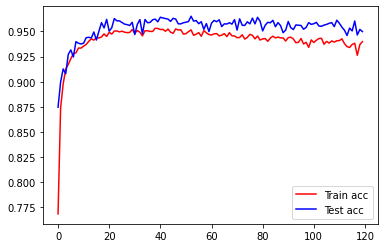

In [ ]:
plt.plot(range(120), model3.history['accuracy'], 'r', label='Train acc')
plt.plot(range(120), model3.history['val_accuracy'], 'b', label='Test acc')
plt.legend()

## Polt the training loss and testing loss

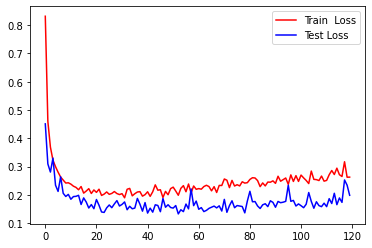

In [ ]:
plt.plot(range(120), model3.history['loss'], 'r', label='Train  Loss')
plt.plot(range(120), model3.history['val_loss'], 'b', label='Test Loss')
plt.legend()

In [ ]:
predictions = model.predict(testx)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = y_test = [np.argmax(probas) for probas in testy]

In [ ]:
from sklearn import metrics as m

print("Precision_weighted:", m.precision_score(y_test, y_pred, average="weighted")*100)
print("Recall_weighted:", m.recall_score(y_test, y_pred, average="weighted")*100)
print("F1_weighted:", m.f1_score(y_test, y_pred, average="weighted")*100)

Precision_weighted: 94.58770771669458
Recall_weighted: 94.97907949790795
F1_weighted: 94.11300964699983


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


Number of misclassified attacks:  372
Percentage of misclassified attacks:  5.02092050209205
-------------------------------------------------- Confusion Matrix --------------------------------------------------


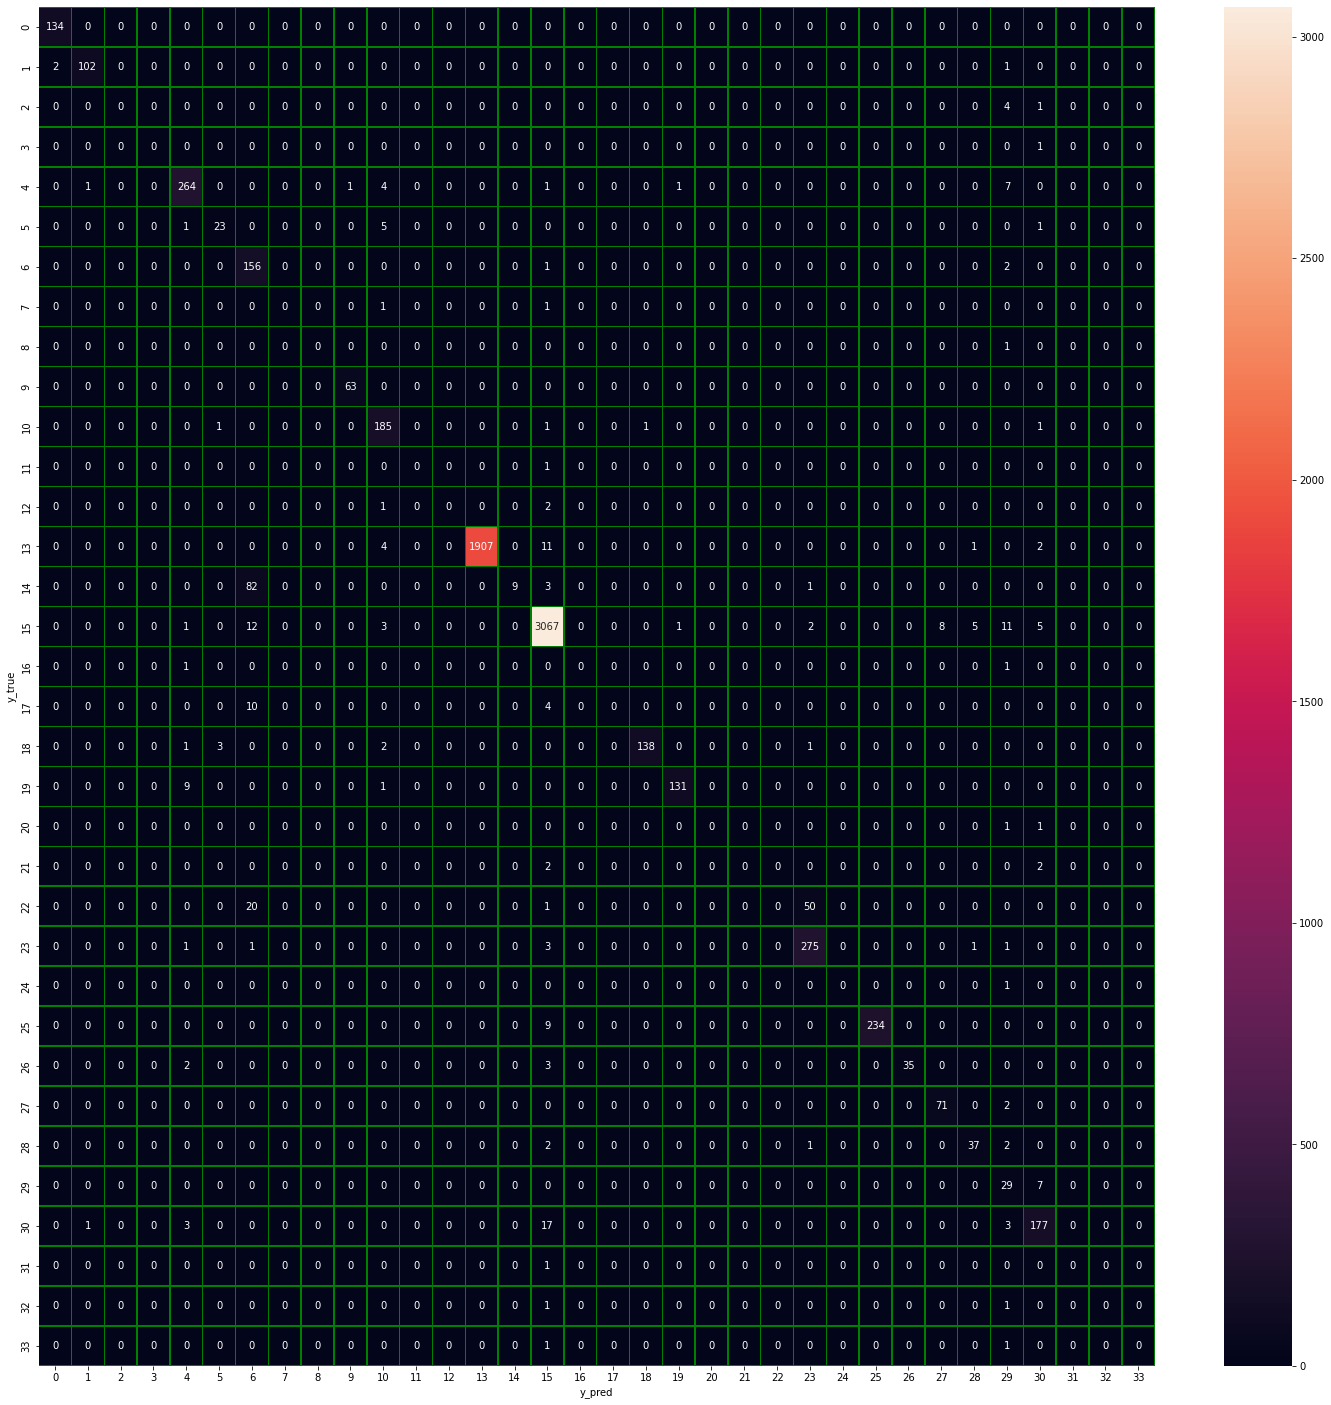

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print("Number of misclassified attacks: ", (len(y_test)-np.trace(cm)))
print("Percentage of misclassified attacks: ", (len(y_test)-np.trace(cm))*100/len(y_test))
print("-"*50, "Confusion Matrix", "-"*50)
f,ax=plt.subplots(figsize=(25,25))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### ++++++++++++++++++++++++++++++++++++++++END++++++++++++++++++++++++++++++++++++++++++++